# Example notebook for import-export operations with pyMOE

In the following is exemplified how to: 

* Transform a (multi-layer) .gds file into a grayscale image file (allowed extensions as accepted by opencv, e.g. .tiff, .png, .jpg ...)

* Transform a grayscale image file into a dithered image file

* Transform a grayscale image file (.tiff, .png, ...) into a gds file (with  squared pixels) 

* Extra: Merge all pixels (or shapes) in a layer inside a .gds file 

In [1]:
# Notebook display options, change as your preference/system
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w",'bbox_inches':None}

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [2]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

from matplotlib import pyplot as plt 
import numpy as np 

from scipy.constants import micro, nano, milli

import pyMOE as moe 
from pyMOE.generate import *  
from pyMOE.importing import *


## Export a created mask using gdsconverter

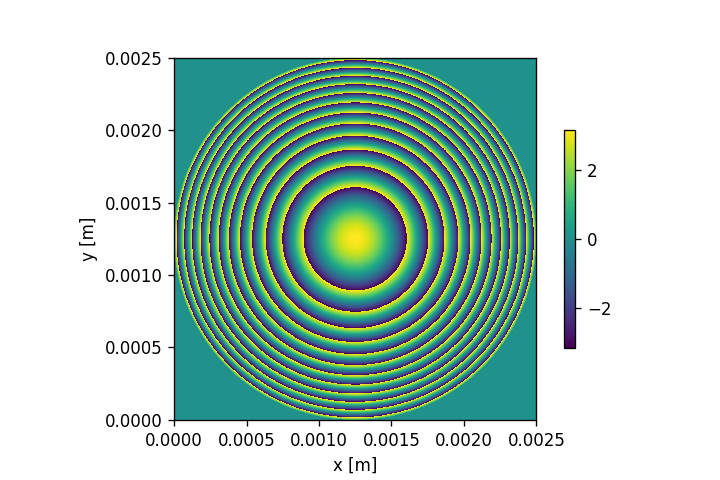

In [3]:
###Here we create a gds/dxf file using the generate and the gdsconverter modules 

####generate a fresnel phase mask and save it into gds 
N_pixels = 2500# nr of pixels 
focal_distance = 100e-3 # focal distance in m 

refractive_index_633 = 1.630115
wavelength = 633*nano

mask_width = 2500*micro #x-size in um
mask_height = 2500*micro #y-size in um
radius = 2500*micro/2
n = 10  # number of gray levels 


##############
###Fresnel mask with a truncated circular aperture 

# Create empty mask
aperture = moe.generate.create_empty_aperture(0,mask_width, N_pixels, 0, mask_height, N_pixels)

center = (2500*micro/2, 2500*micro/2)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture, focal_distance, wavelength, radius=radius, center = center)
moe.plotting.plot_aperture(mask )


## Convert phase mask to height map

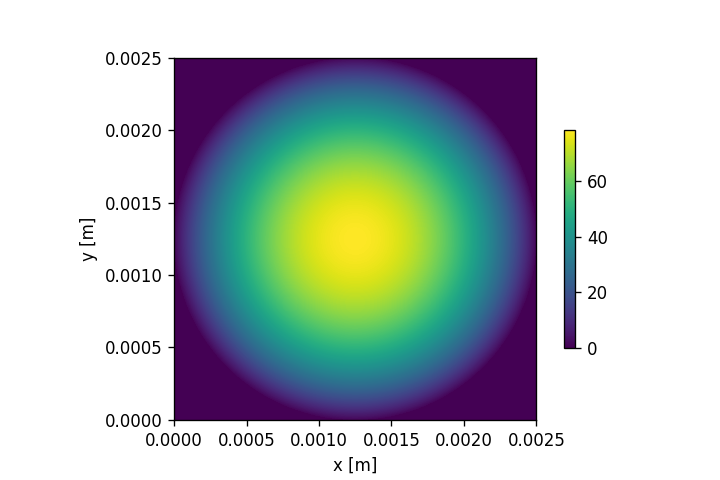

Maximum height of the mask: 1.0045785293160772 μm
Discretizing mask to number of gray levels:  10


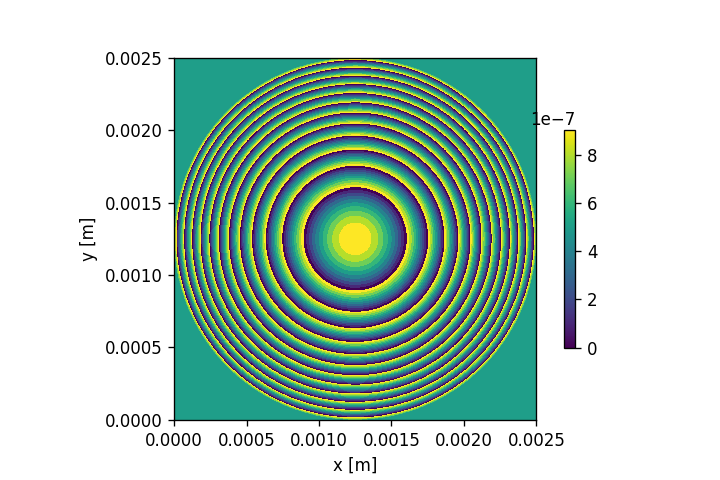

In [4]:

# Unwraps the phase and plots the aperture
mask.phase_unwrap()
moe.plotting.plot_aperture(mask)

# Converts the phase to height 
mask.phase2height(wavelength, refractive_index_633)

#moe.plotting.plot_aperture(mask)

# define the maximum height of the mask

height_2pi = moe.sag.phase2height(2*np.pi, wavelength, refractive_index_633)

print(f"Maximum height of the mask: {height_2pi/micro} μm")

mask.modulos(height_2pi, normalize_to_max=True)
#moe.plotting.plot_aperture(mask)

print("Discretizing mask to number of gray levels: ", n)
mask.discretize(n)
moe.plotting.plot_aperture(mask)

In [5]:
# Export the aperture as a 8-bit BMP file 
moe.export.export_img(mask,"test.bmp")

# Export the aperture as a 16-bit TIFF file 
moe.export.export_img(mask,"test.tiff", 16)

Saved aperture into a grayscale image test.bmp
Saved aperture into a grayscale image test.tiff


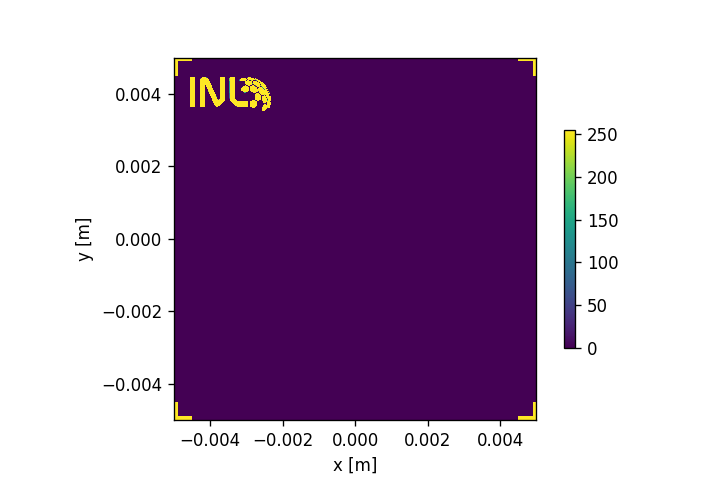

In [ ]:
# Import the BMP file as an aperture for use in the following

inputfile, width_file, height_file = "test.bmp", mask_width, mask_height

pix_size= 1e-6 

canvas_width, canvas_height = 10e-3, 10e-3

npix_x =  canvas_width/pix_size 
npix_y =  canvas_height/pix_size 


npixs2 = int(np.round(canvas_width/npix_x, 0)), int(np.round(canvas_height/npix_y, 0) )

aperture1 = import_img("gs_bmp_fiducials_10x10mm_1um.png",  canvas_width, canvas_height)

moe.plotting.plot_aperture(aperture1 )



canvas_width, canvas_height = mask_width, mask_height

npixs2 = int(np.round(canvas_width/pix_size, 0)), int(np.round(canvas_height/pix_size, 0) )

aperture_blank = moe.generate.create_empty_aperture(-canvas_width/2, canvas_width/2, npixs2[0], \
                                                -canvas_height/2, canvas_height/2, npixs2[1])
aperture = aperture_blank

xc = 2e-3
yc = -2e-3


aperture2 = import_img(inputfile, width_file, height_file, aperture1, center=(xc,yc) )

moe.plotting.plot_aperture(aperture2 )


# Export the aperture as a 8-bit BMP file 
moe.export.export_img(aperture2,"two_masks.bmp")


In [ ]:
del aperture2 

# Import the BMP file as an aperture for use in the following
canvas_width, canvas_height = 10e-3, 10e-3

npixs2 = int(np.round(canvas_width/pix_size, 0)), int(np.round(canvas_height/pix_size, 0) )

aperture_blank = moe.generate.create_empty_aperture(-canvas_width/2, canvas_width/2, npixs2[0]+1, \
                                                -canvas_height/2, canvas_height/2, npixs2[1]+1)
aperture = aperture_blank

xc = 2e-3
yc = -2e-3

aperture2 = import_img(inputfile, width_file, height_file, aperture, center=(xc,yc) )


added = moe.generate.aperture_add(aperture1, aperture2)

# Export the aperture as a 8-bit BMP file 
moe.export.export_img(added,"two_masks-added.bmp")


## Export mask to gds and dxf files


`.dxf` files are recorded with layer names with the naming convention   `LevelXXX_0.000` where `XXX` is the layer number and `0.000` is the respetive expected depth for that layer in microns.

In [ ]:
gdsname = 'examplemask.gds' # name of dxf file+
dxfname = 'examplemask.dxf' # name of dxf file+


#initialize the GDS converter class 
gdsmask = moe.GDSMask(mask)

# Create layout and merge polygons together if merge=True 
gdsmask.create_layout(mode="raster", merge=True)

gdsmask.write_gds(gdsname)
gdsmask.write_gds(dxfname)

## Convert height map dxf file to grayvalue from calibration lookup table



In [ ]:
gscalibration = moe.GrayscaleCalibration()

# load calibration file
gscalibration.load_calibration("calibration.csv")


# Load mask file
gscalibration.load_gdsfile(dxfname)

# Extracts the height levels from the layer names
gscalibration.get_levels_from_layer_names()
gscalibration.plot_calibration()



# Adjust the height offset gray values
height_offset = -0.2
gscalibration.adjust_grayvalues(height_offset)
gscalibration.plot_calibration()

outfile = dxfname.replace(".dxf", "_grayscale.dxf")

gscalibration.calibrate_layer_names()


# Add fiducials and alignment marks to the mask

corner_length = 500#*micro
corner_width = 100#*micro

field_width = 10000 #*micro
field_height = 10000 #*micro

# Layer number of the fiducials and label names
layer = "layer127"
gscalibration.add_corners(field_width, field_height, corner_length, corner_width, layer)

# Text to use as label
label = "label 01"
gscalibration.add_label(label, position=(-4000, -4000), mag=1000, layer=layer)

gscalibration.save_calibrated_gdsfile(outfile)




## Transform layered .gds file into a grayscale image

In [ ]:
##Start with an existing file 
#Might take a while 
infile = gdsname
outfile = gdsname.replace(".gds", ".bmp")

n=10

moe.importing.gds2img(infile, outfile, int(n),  rescaled=N_pixels/mask_width, verbose=True)


## Transform grayscale image into (binary) dithered image 

In [ ]:
##Make a dithered mask from the tiff obtained from the gds 
import pyMOE.dither as dith

inputimg = outfile
ditherimg = inputimg.replace(".bmp", "_dither.tiff")


#make dithering using the floyd steinberg algorithm now
moe.dither.dither_img(inputimg, ditherimg, plotting=True)

## Transform binary image file into single layered .gds file

Transform a dithered image into a gds file, using a fractioning of the image


In [ ]:
infilxe = ditherimg
outfilxe = infilxe.replace(".tiff", ".gds")


pixelx = 1 #um 
pixely = 1 #um 
cellname = "TOP" #name of the gds cell 
graycolor = 0 #black pixels 
frac = 250 #size of frac pixels in the image 

moe.export.grayim2gds_writer_frac(infilxe, outfilxe, pixelx, pixely, cellname, graycolor, frac, verbose=False)

Transform a dithered image into a .gds file, using the whole image 

In [ ]:
infilxe = ditherimg
outfilxe = infilxe.replace(".tiff", "_2.gds")
cellname = "TOP" #name of the gds cell 
graycolor = 0 #black pixels 
pixelx = 1 #um 
pixely = 1 #um 

moe.export.grayim2gds_writer(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=False)

In [ ]:
###Using instances to create the dithered gds file (faster and less heavy files)

#(Takes less than 1 min)
infilxe = ditherimg
outfilxe = infilxe.replace(".tiff", "_instances.gds")

cellname = "tops" #name of the gds cell 
graycolor = 0 #black pixels 
pixelx = 1 #um 
pixely = 1 #um 

moe.export.grayim2gds_writer_klops(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=False)

## Extra: Merging shapes in the single layer .gds file 

The "pixelated" gds files (without instances) are typically large. The file size can be reduced by merging the pixels - the merge operation can be done using the gds_klops module

In [ ]:
import pyMOE.gds_klops as gdsops 

inputfile = ditherimg
outputfile = inputfile.replace(".gds", "_merged.gds")
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile,cellname, layer, datatype ,outputfile )

In [ ]:
#uses the instatiated gds 
inputfile = "fresnel_phase_mask_dithered_instances.gds"
outputfile = "fresnel_phase_mask_dithered_instances+merged.gds"
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile,cellname, layer, datatype ,outputfile )